In [1]:
import pandas as pd
import os
import numpy as np

## Get data

In [2]:
df = pd.read_csv('../data/Customer-Value-Analysis.csv').set_index('Customer')
df.head()

,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
Customer,,,,,,,,,,,,,,,,,,,,,
BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, BU79786 to Y167826
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          9134 non-null   object 
 1   Customer Lifetime Value        9134 non-null   float64
 2   Response                       9134 non-null   object 
 3   Coverage                       9134 non-null   object 
 4   Education                      9134 non-null   object 
 5   Effective To Date              9134 non-null   object 
 6   EmploymentStatus               9134 non-null   object 
 7   Gender                         9134 non-null   object 
 8   Income                         9134 non-null   int64  
 9   Location Code                  9134 non-null   object 
 10  Marital Status                 9134 non-null   object 
 11  Monthly Premium Auto           9134 non-null   int64  
 12  Months Since Last Claim        9134 non-null

### Lets check out target distribution

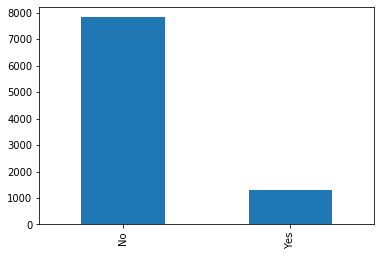

In [4]:
df['Response'].value_counts().plot(kind='bar')

=> the dataset is very unballanced

At this stage, you can upload the dataset into Prevision platform with no need of data transformation 

### Processing not required while using prevision platform 

### Custom Pipeline:
With many data transformation steps it is recommanded to use Pipeline class provided by Scikit-learn that helps to make sequenced transformations in the right order. We can do that using the FeatureUnion estimator offered by scikit-learn. This estimator applies a list of transformer objects in parallel to the input data, then concatenates the results



In [5]:
#df.Response = df.Response.apply(lambda X : 0 if X == 'No' else 1)
X = df.drop(['Response'], axis = 1)
y = df.Response.apply(lambda X : 0 if X == 'No' else 1)

cats = [var for var, var_type in X.dtypes.items() if var_type=='object']
nums = [var for var in X.columns if var not in cats]
#cats.remove('Customer')

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.compose import ColumnTransformer

#source code from : https://www.kaggle.com/schopenhacker75/complete-beginner-guide

#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector(BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names):
        self._feature_names = feature_names 
        
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[self._feature_names].values 


#Defining the steps in the categorical pipeline 
cat_pipeline = Pipeline( [ ( 'cat_selector', FeatureSelector(cats) ),
                          ( 'one_hot_encoder', OneHotEncoder(sparse = False ) ) ] )
    
#Defining the steps in the numerical pipeline     
num_pipeline = Pipeline([
        ( 'num_selector', FeatureSelector(nums) ),
        ('std_scaler', StandardScaler()),
    ])


#Combining numerical and categorical piepline into one full big pipeline horizontally 
#using FeatureUnion
full_pipeline = FeatureUnion( transformer_list = [ ( 'num_pipeline', num_pipeline ),
                                                  ( 'cat_pipeline', cat_pipeline )] 
                            )

In [8]:
#categories=[]
#for k, l in ohe_dict.items():
#    categories.append([f'{k}_{cat}' for cat in list(l)])
#flatten = lambda l: [item for sublist in l for item in sublist]
#categories = flatten(categories)


### Apply data transforamation : 
1. `fit_tranfsorm()` in train dataset
2. `transform()` the test subset 

In [9]:
from sklearn.model_selection import train_test_split, cross_validate
X_train,  X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
#fit and transform the custom transformer in train
X_train_processed = full_pipeline.fit_transform(X_train)
# transform the test with the trainef tansformer
X_test_processed = full_pipeline.transform(X_test)


In [10]:
print('transformed training dataset shape', X_train_processed.shape)
print('transformed training dataset shape', X_test_processed.shape)

transformed training dataset shape (7307, 122)
transformed training dataset shape (1827, 122)


Now we need to persist the transformer that will be needed to make future predictions:

[here](#https://scikit-learn.org/stable/modules/model_persistence.html) a more complete post about model persistance

In [12]:
from joblib import dump, load
#  we will persist the transformer for future use without having to retrain
#https://scikit-learn.org/stable/modules/model_persistence.html
dump(full_pipeline, f'../model/transformer.joblib')

['../model/transformer.joblib']

we will also save the trained one hot encoding categories (we will use it later to display feature importance)

In [13]:
import pickle

cat_step = full_pipeline.get_params()['transformer_list'][-1][-1]
ohe = cat_step.steps[-1][-1]
ohe_categories =dict(zip(cats, ohe.categories_))
output_path = '../model/ohe_categories.pkl'
with open(output_path, 'wb') as output:
        pickle.dump(ohe_categories, output, pickle.HIGHEST_PROTOCOL)


/home/zouna/projects/venv/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


## Model Selection:
We will test out different types of algorithms and evaluate the performances using both the cross validation and train/test elvaluation techniques

In [14]:
from sklearn.metrics import log_loss
from joblib import dump, load
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.linear_model import SGDClassifier

names = ["Nearest Neighbors", "XGBoost", "Random Forest"]

classifiers = [
    KNeighborsClassifier(3),
    GradientBoostingClassifier(),
    RandomForestClassifier()]

scores = {}

# iterate over classifiers
for name, clf in zip(names, classifiers):
    # Cross val prediction    
    cv_preds = cross_val_predict(clf, X_train_processed, y_train, method='predict_proba')
    cv_score = log_loss(y_train, cv_preds)
    
    # holdout data 
    clf.fit(X_train_processed, y_train)
    hd_preds = clf.predict_proba(X_test_processed)
    hd_score = log_loss(y_test, hd_preds)
    
    # append the scores
    scores[name] = [cv_score, hd_score]
    #store the model
    dump(clf, f'../model/{name}.joblib') 
    


In [15]:
for model, perf in scores.items():
    print(f'{model} => CV_AUC : {perf[0]}, Holdout_AUC:{perf[1]}')

Nearest Neighbors => CV_AUC : 0.6210403921626958, Holdout_AUC:0.6183440196177838
XGBoost => CV_AUC : 0.26475707897857265, Holdout_AUC:0.27057581541492454
Random Forest => CV_AUC : 0.09860086499954261, Holdout_AUC:0.07818186978283587


=> Random Seems to perform well, let fine tune it

### Model Fine-Tuning:
Once we have setected the one that seems to perform better (here random forest), we need to fine tune it. The most commun way is GridSearchCV evaluate all the possible combinations of setteled hyperparameter values using cross-validation.

For example, the following code searches for the best combination of hyperparameter values for the RandomForestClassifier:

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

param_grid = [
    {'n_estimators': [100, 200]},
    {'n_estimators': [50, 100, 200], 'max_features': ['log2']},
    {'bootstrap': [False], 'n_estimators': [150, 300], 'max_features': [2, 4]},
]
# about how to use the scorer strategy for the grid search:
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring
scorer = make_scorer(log_loss)

RF = RandomForestClassifier()
grid_search = GridSearchCV(RF, param_grid, cv=5,
                           scoring=scorer,
                           return_train_score=True)

grid_search.fit(X_train_processed, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [17]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 2, 'n_estimators': 300}

In [19]:
sk_best = grid_search.best_estimator_

# Cross val prediction    
cv_preds = cross_val_predict(sk_best, 
                             X_train_processed, y_train, 
                             method='predict_proba')
best_cv_score = log_loss(y_train, cv_preds)

# holdout data 
sk_best.fit(X_train_processed, y_train)
hd_preds = sk_best.predict_proba(X_test_processed)
best_hd_score = log_loss(y_test, hd_preds)


#store the model
dump(sk_best, f'../model/best.joblib') 

['../model/best.joblib']

In [20]:
#print(f'best => CV_AUC : {best_cv_score}, Holdout_AUC:{best_hd_score}')

## Make single prediction:
for our projetc we will use the model to simulate deffierent values of the features and make single prediction for each simulation: we proceed as follows:

In [21]:
# example of new enty
new_entry = X_test.loc[X_test.index[-1]].to_frame()
# pass it throug the pipeline
new_entry_processed = full_pipeline.transform(new_entry.T)
# make prediction
sk_best.predict_proba(new_entry_processed)

array([[0.87333333, 0.12666667]])

In [22]:
# take the argmax
sk_best.predict(new_entry_processed)

array([0])

### Classification performances
Now we will save model performances corresponding to different metrics such as precision_score, recall_score, accuracy_score and f1_score, we will use it later to display a pretty bar chart in our dash app

In [23]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Cross val prediction    
cv_one_preds = cross_val_predict(sk_best, 
                             X_train_processed, y_train, 
                             method='predict')



In [24]:
perf = {'accuracy' : accuracy_score(y_train, cv_one_preds),
       'precision': precision_score(y_train, cv_one_preds),
       'recall' : recall_score(y_train, cv_one_preds),
       'f1_score': f1_score(y_train, cv_one_preds)}

# persist the result
output_path = '../model/sk_best_performances.pkl'
with open(output_path, 'wb') as output:
        pickle.dump(perf, output, pickle.HIGHEST_PROTOCOL)